In [31]:
import copy
import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import shioaji as sj
import talib as ta
import torch
import wandb

from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import KFold
from tqdm import tqdm

In [32]:
SEQ_LEN = 120
BATCH_SIZE = 32
EPOCHS = 20
D_MODEL = 18
NUM_HEADS = 6
NUM_ENCODER_LAYERS = 3
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-4
K = 5
FEATURE_NUM = None
PATIENCE = 3
MIN_DELTA_PERCENTAGE = 0.01

## Parameters
MIN_LATER = 15  # The minute we want to predict in the future
DEVICE = (torch.cuda.is_available() and 'cuda:0') or 'cpu'

BEGIN_TIME = datetime.time(9, 15)
END_TIME = datetime.time(13, 15)

In [33]:
def draw_plot(x_data: pd.DataFrame, y_data: pd.DataFrame, x_label: str, y_label: str) -> None:
    fig = plt.figure(figsize=(7, 4))
    plt.scatter(x_data, y_data, s = 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def keltner_bands(close: np.ndarray, high: np.ndarray, low: np.ndarray, period: int, multiplier: int, position: int) -> tuple:
    mid = ta.EMA(close, timeperiod = period)
    mid = np.nan_to_num(mid, nan = mid.iloc[period - 1])
    kelt_trange = np.array([])

    for i in tqdm(range(1, len(close)), desc = "Calculating kelner bands ", position = position, leave = True):
        tem_trange = max(
            high.iloc[-i] - low.iloc[-i],
            abs(high.iloc[-i] - close.iloc[-i - 1]),
            abs(low.iloc[-i] - close.iloc[-i - 1])
        )
        kelt_trange = np.append(tem_trange, kelt_trange)
    kelt_trange = np.append(high.iloc[0] - low.iloc[0], kelt_trange)
    atr = ta.EMA(kelt_trange, timeperiod = period)
    atr = np.nan_to_num(atr, nan = atr[period - 1])
    upper = mid + atr * multiplier
    lower = mid - atr * multiplier

    return upper, mid, lower

def KDJ(high: np.ndarray, low: np.ndarray, close: np.ndarray, period: int, signal_k: int, signal_d: int, position: int) -> tuple:
    _alpha_k = 2 / (signal_k + 1)
    _alpha_d = 2 / (signal_d + 1)

    lowest = ta.MIN(low, timeperiod = period)
    lowest = np.nan_to_num(lowest, nan = lowest.iloc[period - 1])
    highest = ta.MAX(high, timeperiod = period)
    highest = np.nan_to_num(highest, nan = highest.iloc[period - 1])

    rsv = (close - lowest) / (highest - lowest) * 100
    
    K = np.array([50])
    D = np.array([50])
    J = np.array([50])
    
    for i in tqdm(range(1, len(close)), desc = "Calculating KDJ ", position = position, leave = True):
        K = np.append(K, int(_alpha_k * ((K[-1] + 2 * rsv.iloc[i]) / 3) + (1 - _alpha_k) * K[-1] + 0.5))
        D = np.append(D,  int(_alpha_d * ((D[-1] + 2 * K[-1]) / 3) + (1 - _alpha_d) * D[-1] + 0.5))
        J = np.append(J, 3 * K[-1] - 2 * D[-1])

    return K, D, J

def load_and_check(data_path: str, start_date: datetime.date = None, end_date: datetime.date = None) -> pd.DataFrame:
    global BEGIN_TIME, END_TIME

    data = pd.read_csv(data_path, dtype = {
        'Date': str,
        'open': np.int16,
        'high': np.int16,
        'low': np.int16,
        'close': np.int16,
        'volume': np.int16
    }, index_col = 0)
    data.index = pd.to_datetime(data.Date)
    data = data.between_time(BEGIN_TIME, END_TIME)

    if start_date is not None:
        data = data[(data.index.date >= start_date) & (data.index.date <= end_date)]
 
    IS_MISSING_DATA = False
    missing_time_index = []
    for i in range(1, len(data.index)):
        if data.index[i] - data.index[i - 1] != datetime.timedelta(minutes = 1) and data.index[i].time() != BEGIN_TIME:
            if IS_MISSING_DATA == False:
                IS_MISSING_DATA = True
                print('Not continuous time: ')
                
            print('\t', data.index[i - 1], data.index[i])
            missing_time_index.append(i - 1)

    finish = 0
    if IS_MISSING_DATA:
        print('=' * 50)

        for int_index in missing_time_index:
            time_delta = (data.index[int_index + finish + 1] - data.index[int_index + finish]).seconds // 60
            Entity_delta = data.Open.iloc[int_index + finish + 1] - data.Close.iloc[int_index + finish]
            High_delta = data.High.iloc[int_index + finish + 1] - data.High.iloc[int_index + finish]
            Low_delta = data.Low.iloc[int_index + finish + 1] - data.Low.iloc[int_index + finish]
            Volume_delta = data.Volume.iloc[int_index + finish + 1] - data.Volume.iloc[int_index + finish]
            print(Entity_delta)

            for minute in range(1, time_delta):
                print(f"Missing data at {data.index[int_index + finish]}")
                print(data.iloc[int_index + finish - 1: int_index + finish + 4][:-1], end = '\n\n')
                
                time_for_missing_data = (data.index[int_index + finish] + datetime.timedelta(minutes = 1))
                new_data = pd.DataFrame({
                    'Date': time_for_missing_data,
                    'Open': data.Close.iloc[int_index + finish],
                    'High': round(data.High.iloc[int_index + finish - minute + 1] + High_delta * minute / (time_delta - 1)),
                    'Low': round(data.Low.iloc[int_index + finish - minute + 1] + Low_delta * minute / (time_delta - 1)),
                    'Close': round(data.Close.iloc[int_index + finish - minute + 1] + Entity_delta * minute / (time_delta - 1)),
                    'Volume': round(data.Volume.iloc[int_index + finish - minute + 1] + Volume_delta * minute / (time_delta - 1))
                }, index = [time_for_missing_data])
                data = pd.concat([data.iloc[:int_index + finish + 1], new_data, data.iloc[int_index + finish + 1:]])
                finish += 1
                print(data.iloc[int_index + finish - 1: int_index + finish + 4], end = '\n\n')

        int_index_for_all_data = [i for i in range(len(data))]
        data.insert(0, '', int_index_for_all_data)
        data.to_csv(data_path, index = False)

        load_and_check(data_path)
    else:
        print(f"Succeed to load and check the data at '{data_path}'")
        return data
    

In [34]:
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, TXF, position_start, TSMC = None):
        self.TXF = torch.cat((
            torch.unsqueeze(torch.tensor(TXF.Open.values), 1),
            torch.unsqueeze(torch.tensor(TXF.High.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Low.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Close.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Volume.values), 1)
        ), 1)
        # self.TSMC = torch.unsqueeze(torch.tensor(TSMC.Close.values), 1)
        # print(self.TXF.shape)
        # print(self.TSMC.shape)

        self.TXF_close = torch.unsqueeze(torch.tensor(TXF.Close.values), 1).double()
        # print(self.TXF_close.shape)

        self.data_len = self.TXF.shape[0]

        self.sma_short = ta.SMA(TXF.Close, timeperiod = 3)
        self.sma_short = torch.tensor(np.nan_to_num(self.sma_short, nan = self.sma_short.iloc[2]))
        self.sma_short = torch.unsqueeze(self.sma_short, 1)

        self.sma_long = ta.SMA(TXF.Close, timeperiod = 9)
        self.sma_long = torch.tensor(np.nan_to_num(self.sma_long, nan = self.sma_long.iloc[8]))
        self.sma_long = torch.unsqueeze(self.sma_long, 1)

        self.adosc = ta.ADOSC(TXF.High, TXF.Low, TXF.Close, TXF.Volume, fastperiod = 6, slowperiod = 15)
        self.adosc = torch.tensor(np.nan_to_num(self.adosc, nan = self.adosc.iloc[14]))
        self.adosc = torch.unsqueeze(self.adosc, 1)

        self.bband_upper, self.bband_middle, self.bband_lower = ta.BBANDS(TXF.Close, timeperiod = 20, nbdevup = 2, nbdevdn = 2)

        self.bband_upper = torch.tensor(np.nan_to_num(self.bband_upper, nan = self.bband_upper.iloc[19]))
        self.bband_upper = torch.unsqueeze(self.bband_upper, 1)

        self.bband_middle = torch.tensor(np.nan_to_num(self.bband_middle, nan = self.bband_middle.iloc[19]))
        self.bband_middle = torch.unsqueeze(self.bband_middle, 1)

        self.bband_lower = torch.tensor(np.nan_to_num(self.bband_lower, nan = self.bband_lower.iloc[19]))
        self.bband_lower = torch.unsqueeze(self.bband_lower, 1)

        self.keltner_upper, self.keltner_middle, self.keltner_lower = keltner_bands(TXF.Close, TXF.High, TXF.Low, 20, 1.5, 0)
        self.keltner_upper = torch.tensor(self.keltner_upper)
        self.keltner_upper = torch.unsqueeze(self.keltner_upper, 1)

        self.keltner_middle = torch.tensor(self.keltner_middle)
        self.keltner_middle = torch.unsqueeze(self.keltner_middle, 1)

        self.keltner_lower = torch.tensor(self.keltner_lower)
        self.keltner_lower = torch.unsqueeze(self.keltner_lower, 1)

        self.K, self.D, self.J = KDJ(TXF.High, TXF.Low, TXF.Close, 9, 3, 3, 0)
        self.K = torch.tensor(self.K)
        self.K = torch.unsqueeze(self.K, 1)

        self.D = torch.tensor(self.D)
        self.D = torch.unsqueeze(self.D, 1)

        self.J = torch.tensor(self.J)
        self.J = torch.unsqueeze(self.J, 1)

    def __len__(self):
        return self.data_len - (SEQ_LEN + MIN_LATER + 1) - 1
    
    def __getitem__(self, idx):
        x_data = torch.cat((
            self.TXF[idx : idx + SEQ_LEN],
            # self.TSMC[idx : idx + SEQ_LEN],
            self.sma_short[idx : idx + SEQ_LEN],
            self.sma_long[idx : idx + SEQ_LEN],
            self.adosc[idx : idx + SEQ_LEN],
            self.bband_upper[idx : idx + SEQ_LEN],
            self.bband_middle[idx : idx + SEQ_LEN],
            self.bband_lower[idx : idx + SEQ_LEN],
            self.keltner_upper[idx : idx + SEQ_LEN],
            self.keltner_middle[idx : idx + SEQ_LEN],
            self.keltner_lower[idx : idx + SEQ_LEN],
            self.K[idx : idx + SEQ_LEN],
            self.D[idx : idx + SEQ_LEN],
            self.J[idx : idx + SEQ_LEN]
        ), 1)

        y_data = self.TXF_close[idx + SEQ_LEN + MIN_LATER + 1]

        return x_data, y_data

class PositionEmbedding(torch.nn.Module):
    def __init__(self, d_model: int) -> None:
        super(PositionEmbedding, self).__init__()
        self.linear = torch.nn.Linear(FEATURE_NUM, d_model, dtype = torch.double)

        # Create a matrix of shape (max_len, feature_num)
        pe = torch.zeros(SEQ_LEN, d_model)
        position = torch.arange(0, SEQ_LEN, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.linear(x)
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int) -> None:
        super(MultiHeadAttention, self).__init__()
        
        # d_model should be divisible by num_heads
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.V_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.K_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.Q_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.output_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)

    def scaled_dot_product_attention(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        # Q, V: [batch_size, num_heads, seq_len, d_k]
        # K: [batch_size, num_heads, seq_len, d_k] -> K: [batch_size, num_heads, d_k, seq_len]
        # attention: [batch_size, num_heads, seq_len, seq_len]
        attention = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k).float())

        # attention_prob: [batch_size, num_heads, seq_len, seq_len]
        # It satisfies the sum of the last dimension is 1
        # For example, assume the result of this softmax is a
        # then a[0][0][0][0] + a[0][0][0][1] + ... + a[0][0][0][seq_len - 1] = 1
        attention_prob = torch.nn.functional.softmax(attention, dim = -1)
        output = torch.matmul(attention_prob, V)
        return output
    
    def split_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, seq_len, d_model = x.size()

        # x: [batch_size, seq_len, d_model] -> x: [batch_size, num_heads, seq_len, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        return x
    
    def concat_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, _, seq_len, d_k = x.size()

        # x: [batch_size, num_heads, seq_len, d_k] -> x: [batch_size, seq_len, d_model]
        x = x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return x
    
    def forward(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        Q = self.split_heads(self.Q_linear(Q))
        K = self.split_heads(self.K_linear(K))
        V = self.split_heads(self.V_linear(V))
        # print("-> Split head succeeded!")

        attention_output = self.scaled_dot_product_attention(Q, K, V)
        # print("-> Scaled dot product attention succeeded!")

        output = self.output_linear(self.concat_heads(attention_output))
        # print("-> Concat head succeeded!")
        
        return output

class FeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int) -> None:
        super(FeedForward, self).__init__()
        # self.fully_connected_1 = torch.nn.Linear(d_model, d_ff, dtype = torch.double)
        # self.fully_connected_2 = torch.nn.Linear(d_ff, d_model, dtype = torch.double)
        self.conv1d_1 = torch.nn.Conv1d(in_channels = d_model, out_channels = d_ff, kernel_size = 1, dtype = torch.double)
        self.conv1d_2 = torch.nn.Conv1d(in_channels = d_ff, out_channels = d_model, kernel_size = 1, dtype = torch.double)
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.transpose(1, 2)
        nonliear_output_1 = self.relu(self.conv1d_1(x))
        output = self.conv1d_2(nonliear_output_1)
        return output.transpose(1, 2)

class Encoder(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: int) -> None:
        super(Encoder, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.norm_1 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.norm_2 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # print("Start to encode...")
        attention_output = self.multi_head_attention(x, x, x)
        # print("Get the attention output!\n")

        # print("Start to feed forward...")
        feed_forward_input = self.norm_1(x + self.dropout(attention_output))
        feed_forward_output = self.feed_forward(feed_forward_input)
        output = self.norm_2(feed_forward_input + self.dropout(feed_forward_output))
        # print("Get the feed forward output!\n")
        
        return output

class Transformer(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, num_layers: int, dropout_rate: int) -> None:
        super(Transformer, self).__init__()
        self.d_model = d_model

        self.position_embedding = PositionEmbedding(d_model)
        self.encoder = torch.nn.ModuleList([Encoder(d_model, num_heads, dropout_rate) for _ in range(num_layers)])
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.prepare_output = torch.nn.Linear(SEQ_LEN * D_MODEL, 64, dtype = torch.double)
        self.relu = torch.nn.ReLU()
        self.final_layer = torch.nn.Linear(64, 1, dtype = torch.double)

    def forward(self, x):
        x = self.position_embedding(x)

        encoder_output = x
        for encoder in self.encoder:
            encoder_output = encoder(encoder_output)

        encoder_output = encoder_output.view(encoder_output.shape[0], -1)

        # [batch_size, seq_len] -> [batch_size, 64]
        flatten_encoder_output = self.dropout(self.prepare_output(encoder_output))

        output = self.final_layer(flatten_encoder_output)
        return output


In [35]:
TXF = load_and_check('data/TXF_long.csv')
TXF_test = load_and_check('data/TXFR1_1min.csv', start_date = datetime.date(2023, 1, 1), end_date = datetime.date(2024, 8, 16))
TXF_test = pd.concat([TXF[(TXF.index.date >= datetime.date(2023, 1, 1))], TXF_test[(TXF_test.index.date >= datetime.date(2023, 12, 9))]])

test_dataset = custom_dataset(TXF_test, 0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = False)

test = iter(torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False))
test_x, test_y = next(test)
FEATURE_NUM = test_x.shape[2]

Succeed to load and check the data at 'data/TXF_long.csv'
Succeed to load and check the data at 'data/TXFR1_1min.csv'


Calculating KDJ : 100%|██████████| 92784/92784 [00:02<00:00, 31360.76it/s]


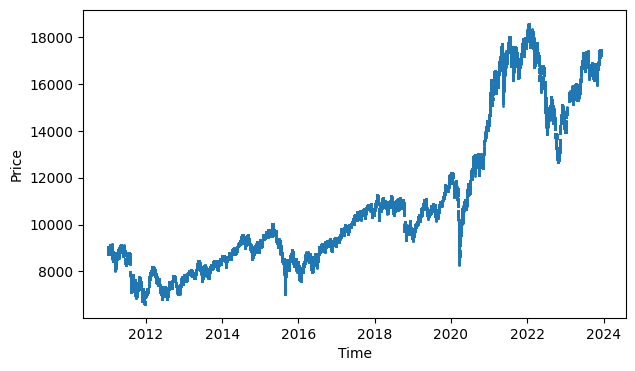

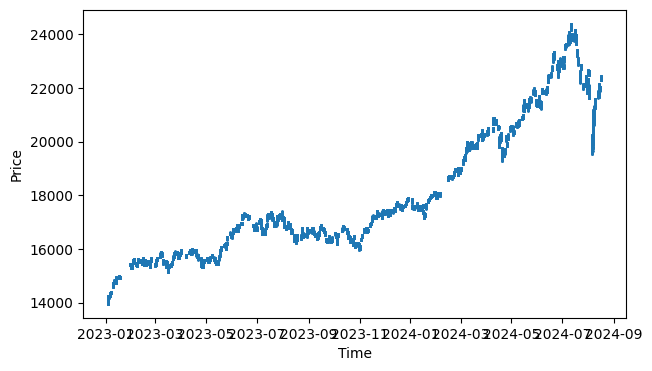

In [39]:
draw_plot(TXF.index, TXF.Close, 'Time', 'Price')
draw_plot(TXF_test.index, TXF_test.Close, 'Time', 'Price')

In [36]:
model_path_1 = 'model_20240912-080122.pth'
model_path_2 = 'model_20240912-085822.pth'
model_path_3 = 'model_20240912-122042.pth'
model_path_4 = 'model_20240912-141254.pth'
model_path_5 = 'model_20240912-160508.pth'
model_path_list = [model_path_1, model_path_2, model_path_3, model_path_4, model_path_5]

model = []
for i in range(5):
    tem_model = Transformer(D_MODEL, NUM_HEADS, NUM_ENCODER_LAYERS, DROPOUT_RATE).to(DEVICE)
    model.append(tem_model)
    model[i].load_state_dict(torch.load(model_path_list[i], weights_only = True))

for i, model in enumerate(model):
    model.eval()

    total_error = 0
    max_error = 0
    min_error = 0
    with torch.no_grad():
        for i, (x_data, y_data) in enumerate(tqdm(test_dataloader, desc = f"Model {i} testing: ")):
            x_data = x_data.to(DEVICE)
            y_data = y_data.to(DEVICE)

            output = model(x_data)
            total_error += torch.abs(output - y_data).item()
            max_error = max(max_error, torch.max(abs(output - y_data)))
            min_error = min(min_error, torch.min(abs(output - y_data)))

    print(f'Model {i}:')
    print(f'\tTotal error: {total_error}')
    print(f'\tMax error: {max_error}')
    print(f'\tMin error: {min_error}')
    print(f'\tAverage error: {total_error / len(test_dataloader)}')
    

Model 0 testing: 100%|██████████| 92648/92648 [05:37<00:00, 274.82it/s]


Model 92647:
	Total error: 1667352699.190755
	Max error: 24364.381035673097
	Min error: 0
	Average error: 17996.63996190695


Model 1 testing: 100%|██████████| 92648/92648 [05:34<00:00, 276.66it/s]


Model 92647:
	Total error: 118061585.91267058
	Max error: 6817.663016575556
	Min error: 0
	Average error: 1274.3025851898647


Model 2 testing: 100%|██████████| 92648/92648 [05:33<00:00, 278.04it/s]


Model 92647:
	Total error: 113986073.10557663
	Max error: 6198.295544948789
	Min error: 0
	Average error: 1230.3133700196079


Model 3 testing: 100%|██████████| 92648/92648 [05:31<00:00, 279.24it/s]


Model 92647:
	Total error: 121546806.61087094
	Max error: 6849.027922085268
	Min error: 0
	Average error: 1311.9204581952222


Model 4 testing: 100%|██████████| 92648/92648 [05:34<00:00, 277.29it/s]

Model 92647:
	Total error: 129878830.36897913
	Max error: 7168.867475850748
	Min error: 0
	Average error: 1401.852499449304
